# Matching der Ergebnisse Scopus und OpenAlex


Für den Fuzzy-Abgleich anhand der Metadatenfelder ist  zu definieren, welche Metadaten hierfür verwendet werden und ab wann ein Match erfolgt (Definition Cutoff-Wert).
Im Folgenden wird dies ermittelt.

In [58]:
import pandas as pd
import numpy as np
from rapidfuzz.distance import Levenshtein, DamerauLevenshtein
import uuid
import matplotlib.pyplot as plt

pd.options.mode.copy_on_write = True

In [59]:
import jupyter_black

jupyter_black.load()

In [62]:
# Daten einlesen
data_doi_matched = pd.read_csv("../data/processed/data_doi_matched.csv")

In [63]:
data_doi_matched.columns

Index(['scopus_id', 'doi', 'scopus_title', 'scopus_name_1st_author',
       'scopus_source_title', 'scopus_volume', 'scopus_publication_year',
       'openalex_id', 'openalex_title', 'openalex_name_1st_author',
       'openalex_source_title', 'openalex_volume',
       'openalex_publication_year'],
      dtype='object')

In [ ]:
data_doi_matched.head()

In [66]:
data_doi_matched["lv_title"] = data_doi_matched.apply(
    lambda x: Levenshtein.normalized_distance(x["scopus_title"], x["openalex_title"]),
    axis=1,
)

data_doi_matched["lv_name_1st_author"] = data_doi_matched.apply(
    lambda x: Levenshtein.normalized_distance(
        x["scopus_name_1st_author"], x["openalex_name_1st_author"]
    ),
    axis=1,
)

data_doi_matched["lv_source_title"] = data_doi_matched.apply(
    lambda x: Levenshtein.normalized_distance(
        x["scopus_source_title"], x["openalex_source_title"]
    ),
    axis=1,
)

In [67]:
data_doi_matched["diff_publication_year"] = data_doi_matched.apply(
    lambda x: 0.0
    if (x["scopus_publication_year"] == x["openalex_publication_year"])
    else (
        0.5
        if (abs(x["scopus_publication_year"] - x["openalex_publication_year"]) == 1)
        else 1.0
    ),
    axis=1,
)

In [68]:
data_doi_matched[data_doi_matched["diff_publication_year"] == 0.0].shape[0]

2545

In [69]:
data_doi_matched[data_doi_matched["diff_publication_year"] == 1.0].shape[0]

0

In [70]:
data_doi_matched[data_doi_matched["diff_publication_year"] == 0.1].shape[0]

0

In [ ]:
data_doi_matched[data_doi_matched["diff_publication_year"] > 0.0].sort_values(
    by="lv_name_1st_author"
)

In [72]:
data_doi_matched["lv_volume"] = data_doi_matched.apply(
    lambda x: Levenshtein.normalized_distance(
        x["scopus_volume"],
        x["openalex_volume"],
    ),
    axis=1,
)

data_doi_matched["lv_volume_cutoff"] = data_doi_matched.apply(
    lambda x: Levenshtein.normalized_distance(
        x["scopus_volume"],
        x["openalex_volume"],
        score_cutoff=0.1,  # only considered exact fit
    ),
    axis=1,
)

In [73]:
# combine scores

data_doi_matched["lv_all"] = (
    0.5
    - data_doi_matched["lv_title"] * 0.1
    + 0.3
    - data_doi_matched["lv_name_1st_author"] * 0.1
    + 0.3
    - data_doi_matched["lv_source_title"] * 0.1
    # + 0.3
    # - data_doi_matched["lv_volume"]
    # + 0.3
    - data_doi_matched["diff_publication_year"]
)

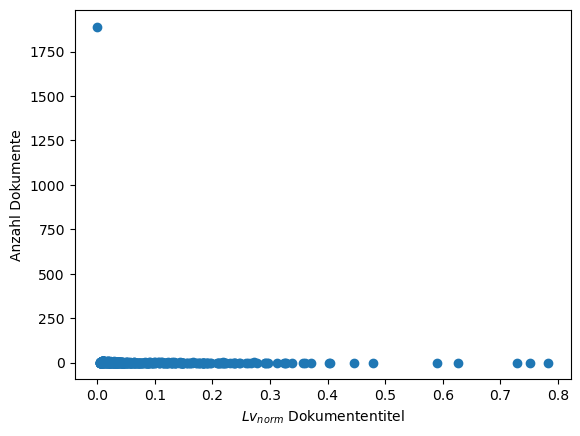

In [74]:
# plot scores lv title distribution
plt.plot(
    data_doi_matched.value_counts(["lv_title"]).keys().tolist(),
    data_doi_matched.value_counts(["lv_title"]),
    "o",
)
plt.ylabel("Anzahl Dokumente")
plt.xlabel("$Lv_{norm}$ Dokumententitel")
# plt.vlines(
#     x=data_doi_matched["lv_title"].mean(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_title"]).max(),
#     colors="grey",
# )
# plt.vlines(
#     x=data_doi_matched["lv_title"].median(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_title"]).max(),
#     colors="black",
# )
# plt.show()
plt.savefig("figures/plot_lv_title.png", dpi=300)

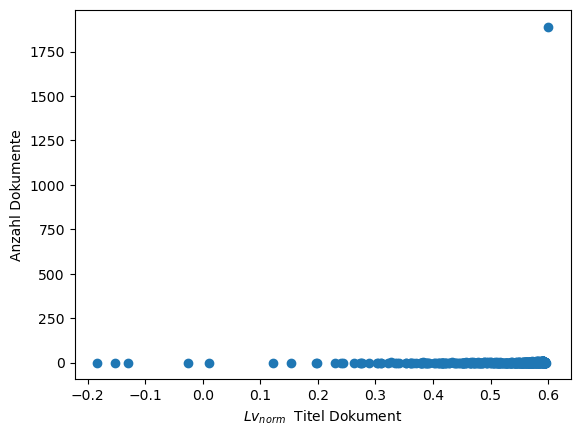

In [75]:
data_doi_matched["lv_title_score"] = 0.6 - data_doi_matched["lv_title"]
# plot scores lv title distribution
plt.plot(
    data_doi_matched.value_counts(["lv_title_score"]).keys().tolist(),
    data_doi_matched.value_counts(["lv_title_score"]),
    "o",
)
plt.ylabel("Anzahl Dokumente")
plt.xlabel("$Lv_{norm}$  Titel Dokument")
# plt.vlines(
#     x=data_doi_matched["lv_title"].mean(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_title"]).max(),
#     colors="grey",
# )
# plt.vlines(
#     x=data_doi_matched["lv_title"].median(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_title"]).max(),
#     colors="black",
# )
plt.show()

In [76]:
data_doi_matched[data_doi_matched["lv_title"] == 0.0].shape[0]

1891

In [77]:
data_doi_matched[data_doi_matched["lv_title"] > 0.5].shape[0]

5

In [ ]:
data_doi_matched[data_doi_matched["lv_title"] > 0.5]

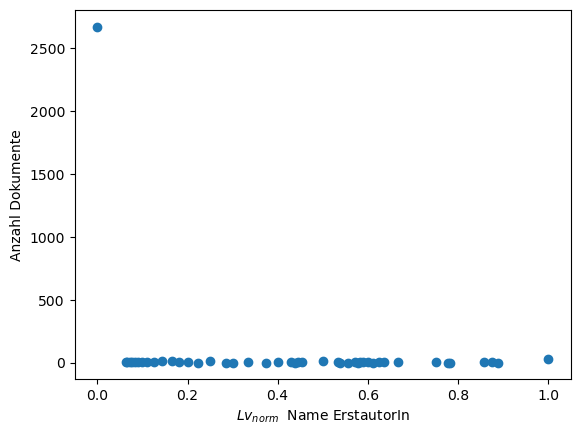

In [79]:
# plot scores lv name 1st author distribution
plt.plot(
    data_doi_matched.value_counts(["lv_name_1st_author"]).keys().tolist(),
    data_doi_matched.value_counts(["lv_name_1st_author"]),
    "o",
)
plt.ylabel("Anzahl Dokumente")
plt.xlabel("$Lv_{norm}$  Name ErstautorIn")
# plt.vlines(
#     x=data_doi_matched["lv_name_1st_author"].mean(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_name_1st_author"]).max(),
#     colors="grey",
# )
# plt.vlines(
#     x=data_doi_matched["lv_name_1st_author"].median(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_name_1st_author"]).max(),
#     colors="black",
# )
# plt.show()
plt.savefig("figures/plot_lv_1st_author.png", dpi=300)

In [80]:
data_doi_matched[data_doi_matched["lv_name_1st_author"] == 0.0].shape[0]

2673

In [81]:
data_doi_matched[data_doi_matched["lv_name_1st_author"] > 0.0].shape[0]

199

In [82]:
data_doi_matched[data_doi_matched["lv_name_1st_author"] > 0.0].shape[
    0
] / data_doi_matched.shape[0] * 100

6.928969359331476

In [ ]:
# why the high scores??
pd.options.display.max_colwidth = 100
data_doi_matched_high_lv = data_doi_matched[
    data_doi_matched["lv_name_1st_author"] > 0.8
]
print(
    data_doi_matched_high_lv[
        [
            # "doi",
            "scopus_name_1st_author",
            "openalex_name_1st_author",
            "lv_name_1st_author",
        ]
    ]
)

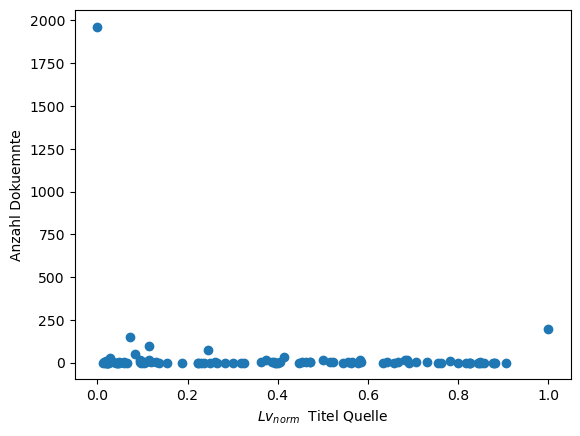

In [84]:
# plot scores lv title distribution
plt.plot(
    data_doi_matched.value_counts(["lv_source_title"]).keys().tolist(),
    data_doi_matched.value_counts(["lv_source_title"]),
    "o",
    # color="green",
    # label="2010-2013",
)
plt.ylabel("Anzahl Dokuemnte")
plt.xlabel("$Lv_{norm}$  Titel Quelle")
# plt.vlines(
#     x=data_doi_matched["lv_source_title"].mean(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_source_title"]).max(),
#     colors="grey",
# )
# plt.vlines(
#     x=data_doi_matched["lv_source_title"].median(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_source_title"]).max(),
#     colors="black",
# )
# plt.show()
plt.savefig("figures/plot_lv_source_title.png", dpi=300)

In [85]:
data_doi_matched[data_doi_matched["lv_source_title"] == 0.0].shape[0]

1964

In [86]:
data_doi_matched[data_doi_matched["lv_source_title"] == 1.0].shape[0]

197

In [ ]:
data_low_lv_source_title = data_doi_matched[data_doi_matched["lv_source_title"] == 1.0]
data_low_lv_source_title[
    ["lv_source_title", "doi", "scopus_source_title", "openalex_source_title"]
]

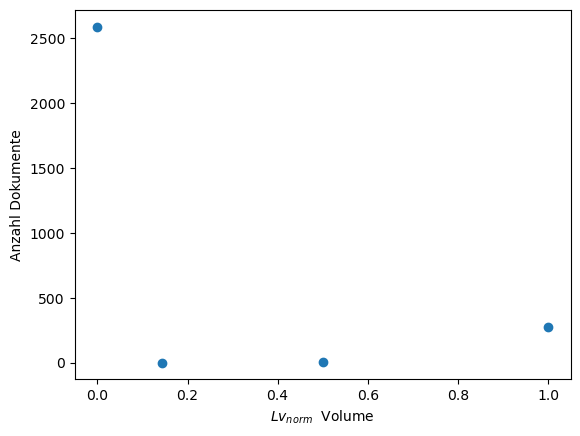

In [88]:
# plot scores lv volume distribution
plt.plot(
    data_doi_matched.value_counts(["lv_volume"]).keys().tolist(),
    data_doi_matched.value_counts(["lv_volume"]),
    "o",
)
plt.ylabel("Anzahl Dokumente")
plt.xlabel("$Lv_{norm}$  Volume")
# plt.vlines(
#     x=data_doi_matched["lv_volume"].mean(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_volume"]).max(),
#     colors="grey",
# )
# plt.vlines(
#     x=data_doi_matched["lv_volume"].median(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_volume"]).max(),
#     colors="black",
# )
# plt.show()
plt.savefig("figures/plot_lv_volume.png", dpi=300)

In [ ]:
res_low_volume = data_doi_matched[data_doi_matched["lv_volume"] > 0.5]
res_low_volume[["scopus_volume", "openalex_volume", "lv_volume"]].sort_values(
    by="lv_volume"
)

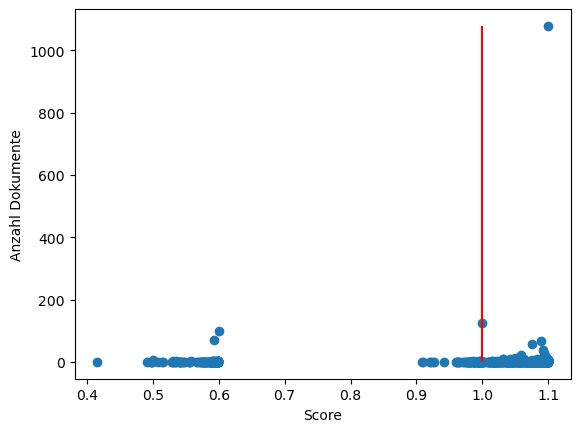

In [90]:
# plot combined score distribution
plt.plot(
    data_doi_matched.value_counts(["lv_all"]).keys().tolist(),
    data_doi_matched.value_counts(["lv_all"]),
    "o",
)
plt.ylabel("Anzahl Dokumente")
plt.xlabel("Score")
plt.vlines(
    x=1.0, ymin=0, ymax=data_doi_matched.value_counts(["lv_all"]).max(), colors="red"
)
# plt.vlines(
#     x=data_doi_matched["lv_all"].mean(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_all"]).max(),
#     colors="grey",
# )
# plt.vlines(
#     x=data_doi_matched["lv_all"].median(),
#     ymin=0,
#     ymax=data_doi_matched.value_counts(["lv_all"]).max(),
#     colors="black",
# )
# plt.show()
plt.savefig("figures/plot_lv_score.png", dpi=300)

In [91]:
data_doi_matched[data_doi_matched["lv_all"] < 1.0000].shape[0]

431

In [ ]:
data_doi_matched[data_doi_matched["lv_all"] < 0.6]